<a href="https://colab.research.google.com/github/Nickqq627/7112029017/blob/main/week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
import yfinance as yf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. 使用 yfinance 獲取台積電股價數據
def get_stock_data():
    ticker = "2330.TW"
    data = yf.download(ticker, start="2024-01-01", end="2024-10-01")
    return data

# 2. 計算技術指標

# 計算簡單移動平均線（SMA）
def calculate_sma(data, window):
    return data['Close'].rolling(window=window).mean()

# 計算相對強弱指數（RSI）
def calculate_rsi(data, period=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 計算MACD指標
def calculate_macd(data, fastperiod=12, slowperiod=26, signalperiod=9):
    ema_fast = data['Close'].ewm(span=fastperiod, adjust=False).mean()
    ema_slow = data['Close'].ewm(span=slowperiod, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signalperiod, adjust=False).mean()
    return macd, signal

In [156]:
# 獲取股價數據
data = get_stock_data()
print()

# 計算技術指標
data['SMA_20'] = calculate_sma(data, window=20)
data['RSI_14'] = calculate_rsi(data, period=14)
data['MACD'], data['MACD_Signal'] = calculate_macd(data)

# 刪除NaN值
data.dropna(inplace=True)

# 定義特徵和標籤（X取第1天到N-1天，y取第2天到N天）
X = data[['Close', 'SMA_20', 'RSI_14', 'MACD', 'MACD_Signal']].iloc[:-1].to_numpy()
y = data['Close'].iloc[1:].to_numpy().reshape(-1, 1)

# 訓練/測試的資料分割，以前80%的天數資料做訓練，後20%來做測試
num_data = X.shape[0]
split_ratio = 0.8
ind_split = int(split_ratio * num_data)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

# 切分日期
split_time = data.index[ind_split]

# 標準化特徵數據
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

[*********************100%***********************]  1 of 1 completed

In [157]:
 # 建立線性迴歸模型
reg_linear = LinearRegression()
reg_linear.fit(X_train_scaled, y_train)

# 預測線性迴歸結果
linear_trainings = reg_linear.predict(X_train_scaled)
linear_predictions = reg_linear.predict(X_test_scaled)

# 建立決策樹模型
reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train_scaled, y_train)

# 預測決策樹結果
tree_trainings = reg_tree.predict(X_train_scaled)
tree_predictions = reg_tree.predict(X_test_scaled)

# 建立隨機森林模型
reg_forest = RandomForestRegressor(n_estimators=100, random_state=42)
reg_forest.fit(X_train_scaled, y_train.ravel())

# 預測隨機森林結果
forest_trainings = reg_forest.predict(X_train_scaled)
forest_predictions = reg_forest.predict(X_test_scaled)

# 將預測結果合在一起
all_linear_pred = np.concatenate((linear_trainings, linear_predictions), axis=0)
all_tree_pred = np.concatenate((tree_trainings, tree_predictions), axis=0)
all_forest_pred = np.concatenate((forest_trainings, forest_predictions), axis=0)

# 計算RMSE
linear_train_rmse = np.sqrt(mean_squared_error(y_train, linear_trainings))
linear_test_rmse = np.sqrt(mean_squared_error(y_test, linear_predictions))

tree_train_rmse = np.sqrt(mean_squared_error(y_train, tree_trainings))
tree_test_rmse = np.sqrt(mean_squared_error(y_test, tree_predictions))

forest_train_rmse = np.sqrt(mean_squared_error(y_train, forest_trainings))
forest_test_rmse = np.sqrt(mean_squared_error(y_test, forest_predictions))

print("Linear Regression Training RMSE:", linear_train_rmse)
print("Linear Regression Testing RMSE:", linear_test_rmse)
print("Decision Tree Training RMSE:", tree_train_rmse)
print("Decision Tree Testing RMSE:", tree_test_rmse)
print("Random Forest Training RMSE:", forest_train_rmse)
print("Random Forest Testing RMSE:", forest_test_rmse)

Linear Regression Training RMSE: 20.68217631394205
Linear Regression Testing RMSE: 18.639005997065894
Decision Tree Training RMSE: 0.0
Decision Tree Testing RMSE: 38.65148768158866
Random Forest Training RMSE: 7.8369828378018
Random Forest Testing RMSE: 29.219829792882102


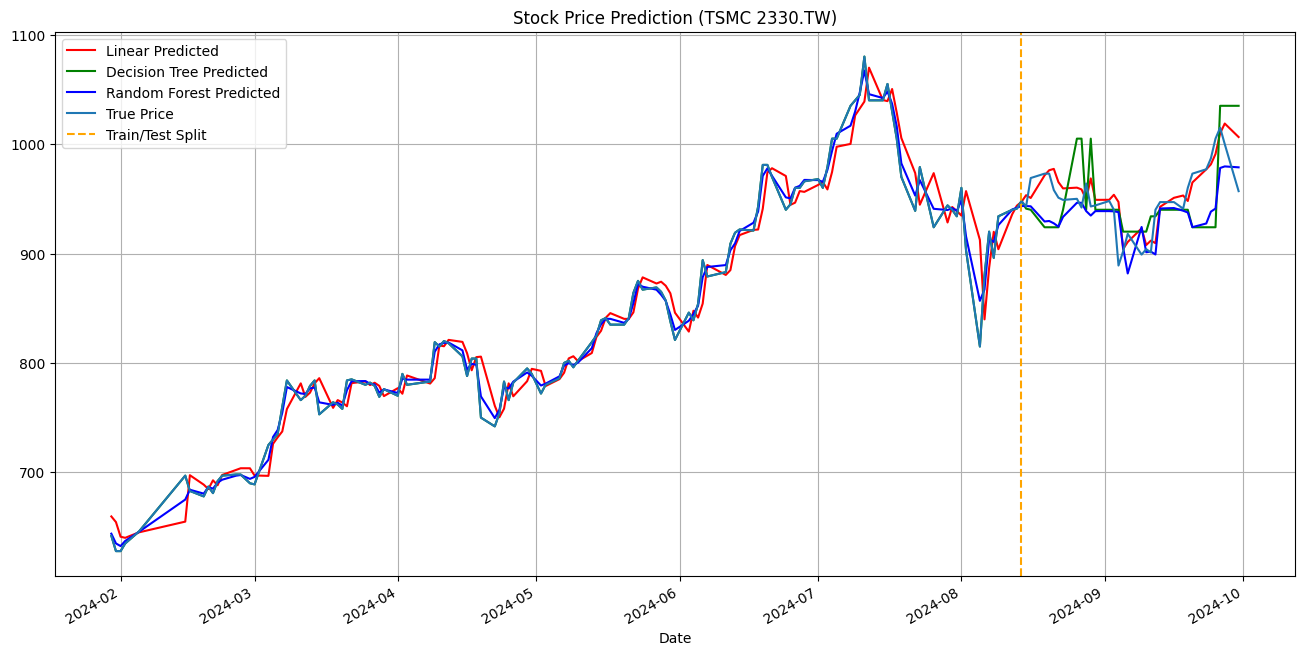

In [158]:
# 獲取分割點對應的日期
split_time = data.index[ind_split]

 # 將預測和真實的股價，放進 df_linear 以便做圖
df_predictions = pd.DataFrame(index=data.index[1:])
df_predictions['Linear Predicted'] = all_linear_pred
df_predictions['Decision Tree Predicted'] = all_tree_pred
df_predictions['Random Forest Predicted'] = all_forest_pred
df_predictions['True Price'] = y

# 畫出結果
plt.figure(figsize=(16, 8))
df_predictions.plot(ax=plt.gca(), title='Stock Price Prediction (TSMC 2330.TW)', grid=True, color=['r', 'g', 'b', 'C0'], legend=True)

# 在圖上加上分割線，標記訓練集和測試集的分界點
plt.axvline(pd.Timestamp(split_time), color='orange', linestyle='--', label='Train/Test Split')

# 顯示圖例
plt.legend()

# 顯示圖表
plt.show()

In [ ]:
# # 對特徵進行標準化
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)

# # 訓練和測試數據集劃分
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# print()
# # 線性回歸模型
# lin_model = LinearRegression()
# lin_model.fit(X_train, y_train)
# lin_predictions = lin_model.predict(X_test)

# # 決策樹模型
# tree_model = DecisionTreeRegressor()
# tree_model.fit(X_train, y_train)
# tree_predictions = tree_model.predict(X_test)

# # 隨機森林模型
# forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
# forest_model.fit(X_train, y_train)
# forest_predictions = forest_model.predict(X_test)

In [ ]:
# # 評估模型表現
# lin_mse = mean_squared_error(y_test, lin_predictions)
# tree_mse = mean_squared_error(y_test, tree_predictions)
# forest_mse = mean_squared_error(y_test, forest_predictions)

# print(f"Linear Regression Mean Squared Error: {lin_mse:.4f}")
# print(f"Decision Tree Mean Squared Error: {tree_mse:.4f}")
# print(f"Random Forest Mean Squared Error: {forest_mse:.4f}")

In [152]:
# 手動繪製K線圖，並啟用工具欄以進行互動
def plot_candlestick_chart(data):
    fig, ax = plt.subplots(figsize=(20, 12))

    # 設置日期格式
    data['Date'] = mdates.date2num(data.index.to_pydatetime())

    # 計算每日均價
    data['Average'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

    for idx, row in data.iterrows():
        color = 'green' if row['Close'] >= row['Open'] else 'red'
        # 畫出K線的高低範圍
        ax.plot([row['Date'], row['Date']], [row['Low'], row['High']], color=color)
        # 畫出K線的實體
        ax.add_patch(
            plt.Rectangle(
                (row['Date'] - 0.2, min(row['Open'], row['Close'])),
                0.4,
                abs(row['Open'] - row['Close']),
                color=color
            )
        )

    # 繪製均價線
    ax.plot(data['Date'], data['Average'], color='blue', label='Daily Average Price', linewidth=2)

    # 設置日期格式化為只顯示年份
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())  # 每年一個刻度

    # 設置標籤和標題
    plt.title('TSMC Candlestick Chart with Daily Average Price')
    plt.xlabel('Year')
    plt.ylabel('Price')

    # 旋轉日期標籤
    plt.xticks(rotation=45)

    # 顯示網格
    plt.grid(True)

    # 添加圖例
    plt.legend()

    # 啟用工具欄 (包含縮放和平移功能)
    plt.tight_layout()
    plt.show()

[*********************100%***********************]  1 of 1 completed


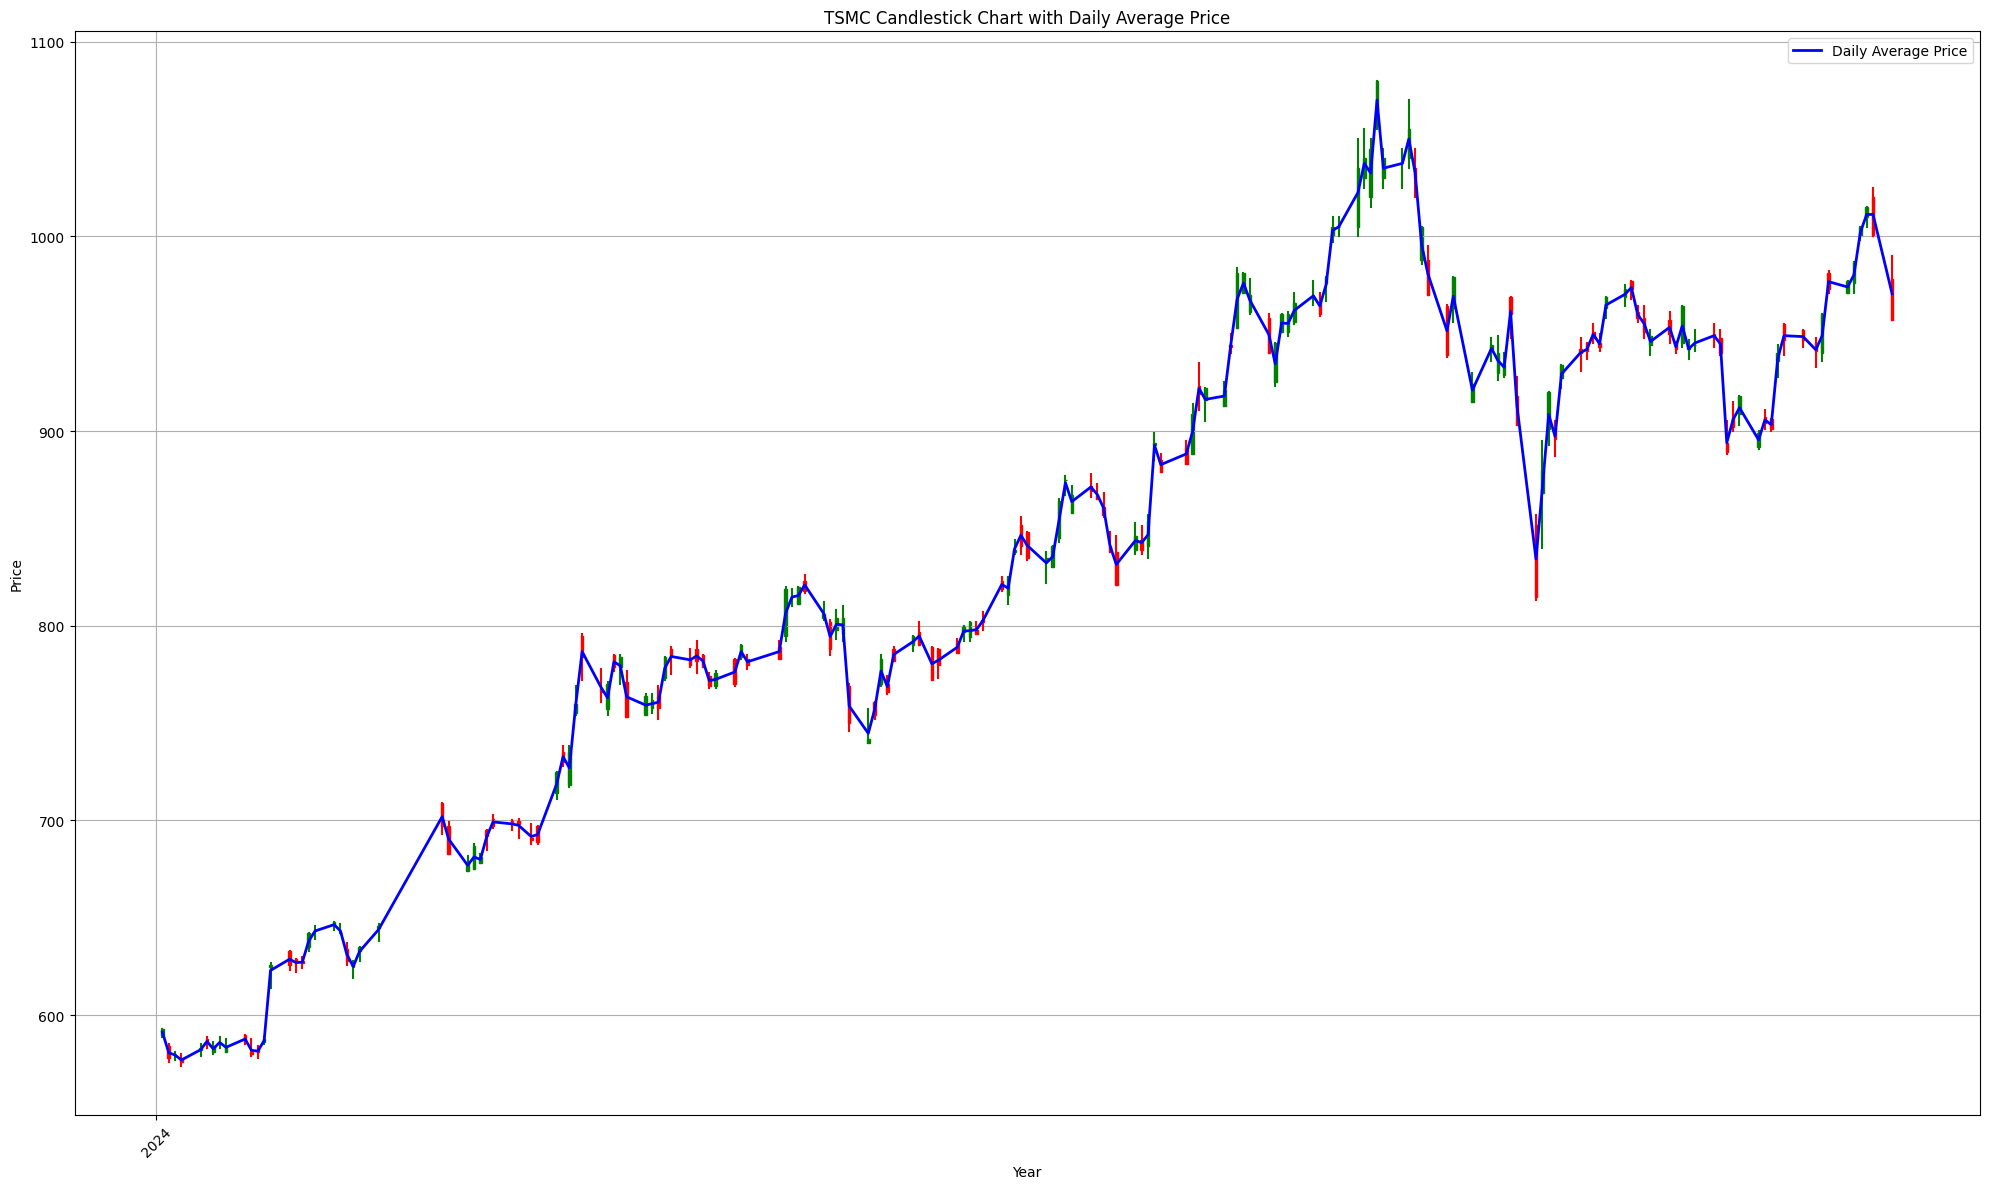

In [153]:
# 繪製K線圖，啟用放大縮小

data = get_stock_data()
plot_candlestick_chart(data)

[*********************100%***********************]  1 of 1 completed


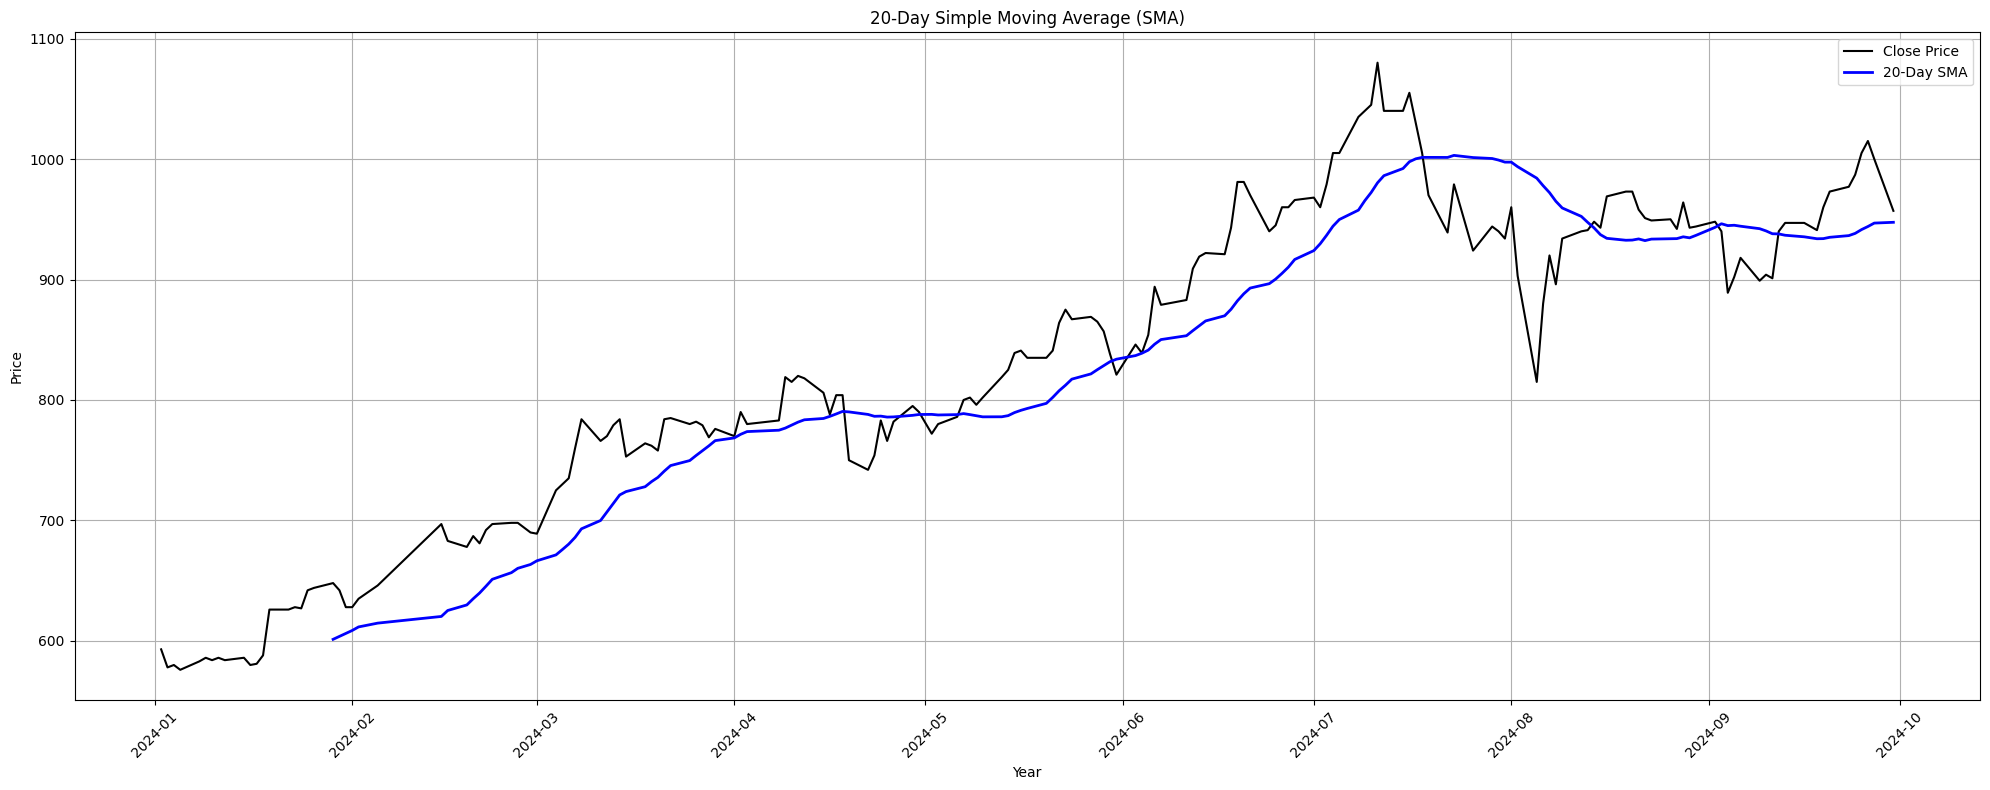

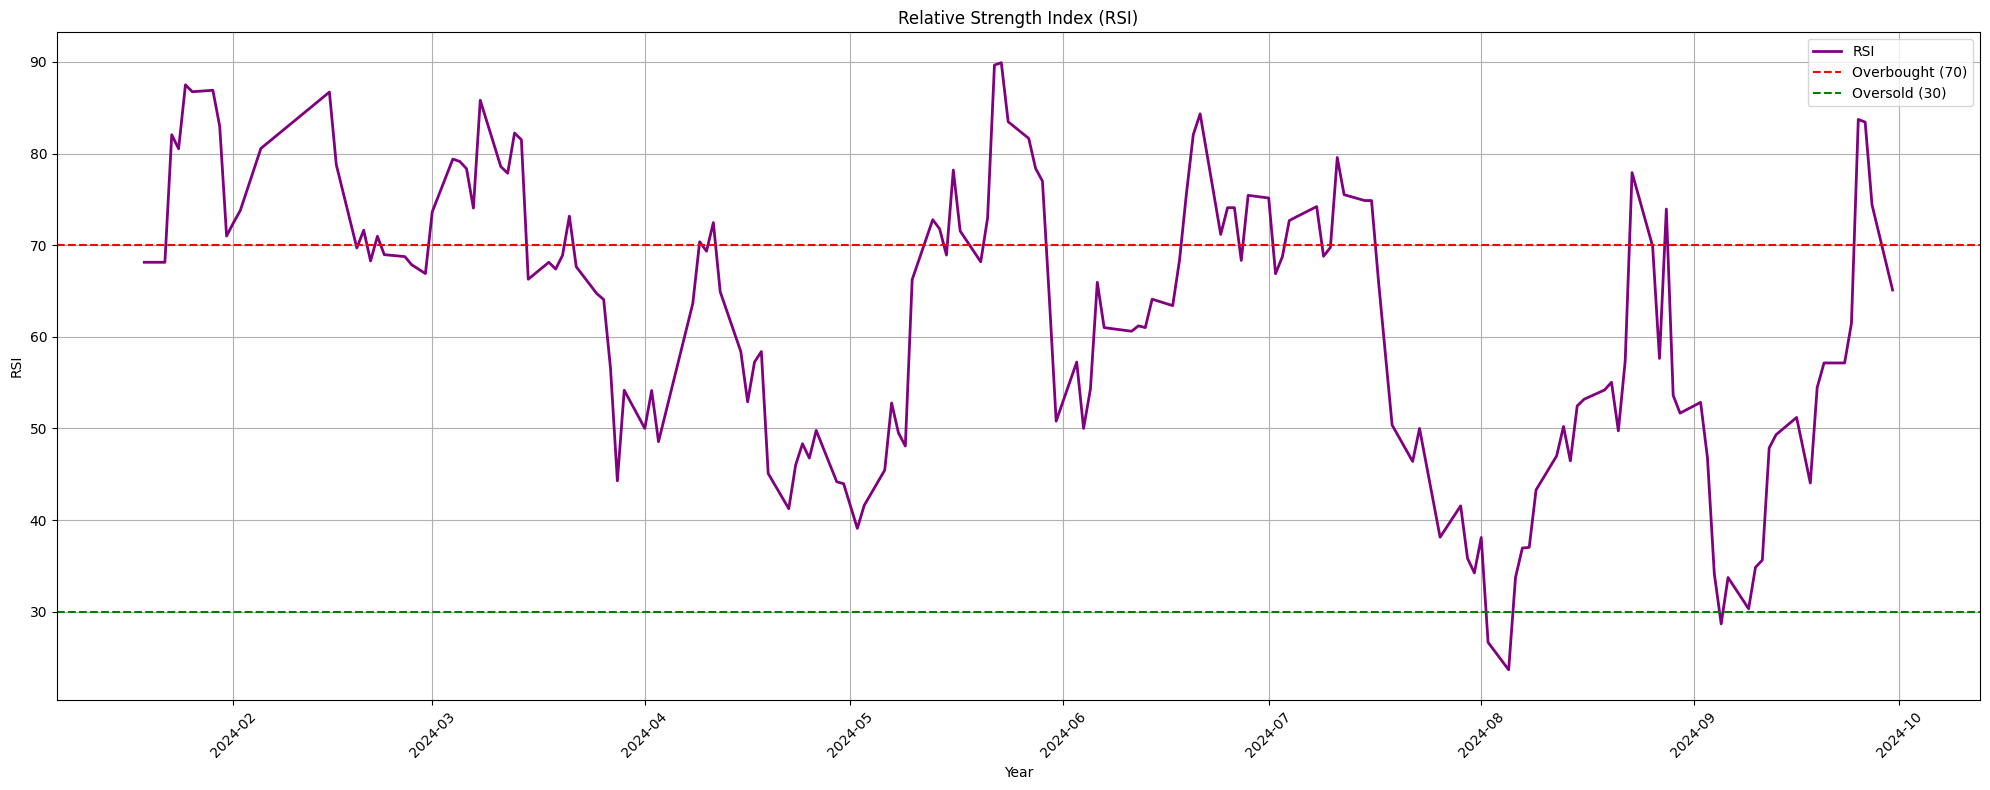

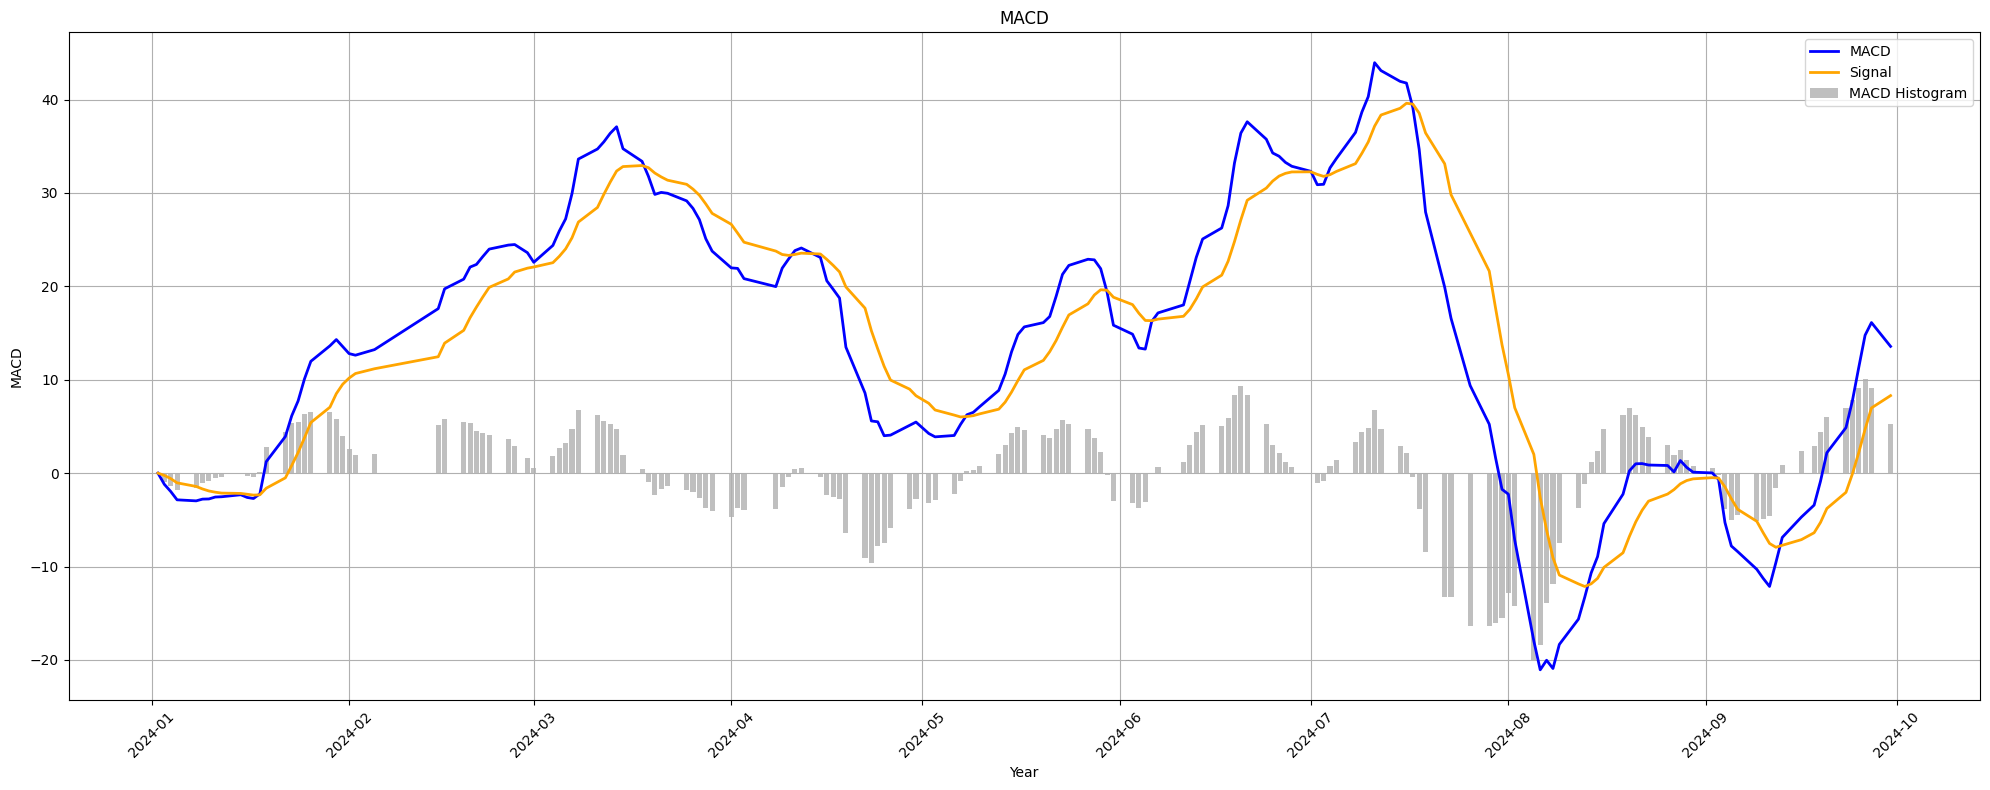

In [162]:
# 繪製 SMA
def plot_sma(data):
  data['SMA'] = calculate_sma(data, window=20)  # 20日SMA
  plt.figure(figsize=(20, 8))
  plt.plot(data.index, data['Close'], label='Close Price', color='black')
  plt.plot(data.index, data['SMA'], label='20-Day SMA', color='blue', linewidth=2)
  plt.title('20-Day Simple Moving Average (SMA)')
  plt.xlabel('Year')
  plt.ylabel('Price')
  plt.grid(True)
  plt.legend()
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

# 繪製 RSI
def plot_rsi(data):
  data['RSI'] = calculate_rsi(data)
  plt.figure(figsize=(20, 8))
  plt.plot(data.index, data['RSI'], label='RSI', color='purple', linewidth=2)
  plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
  plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
  plt.title('Relative Strength Index (RSI)')
  plt.xlabel('Year')
  plt.ylabel('RSI')
  plt.grid(True)
  plt.legend()
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

# 繪製 MACD
def plot_macd(data):
  data['MACD'], data['Signal'] = calculate_macd(data)
  plt.figure(figsize=(20, 8))
  plt.plot(data.index, data['MACD'], label='MACD', color='blue', linewidth=2)
  plt.plot(data.index, data['Signal'], label='Signal', color='orange', linewidth=2)
  plt.bar(data.index, data['MACD'] - data['Signal'], color='grey', alpha=0.5, label='MACD Histogram')
  plt.title('MACD')
  plt.xlabel('Year')
  plt.ylabel('MACD')
  plt.grid(True)
  plt.legend()
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

data = get_stock_data()
plot_sma(data)
plot_rsi(data)
plot_macd(data)